In [1]:
import os
import numpy as np
import cv2
import random
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms



class_names=['control', 'diabetic']


In [2]:
class HeatmapGenerator ():
    
    #---- Initialize heatmap generator
    #---- pathModel - path to the trained densenet model
    #---- nnArchitecture - architecture name DENSE-NET121, DENSE-NET169, DENSE-NET201
    #---- nnClassCount - class count, 14 for chxray-14

 
    def __init__ (self, pathModel, nnClassCount, transCrop):
       
        #---- Initialize the network
        model = torchvision.models.densenet121(pretrained=False)
        num_ftrs = model.classifier.in_features
        model.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))
        model = model.cuda()
        model.load_state_dict(torch.load(pathModel))

        self.model = model
        self.model.eval()
        
        #---- Initialize the weights
        self.weights = list(self.model.features.parameters())[-2]

        #---- Initialize the image transform
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transformList = []
        transformList.append(transforms.Resize((transCrop, transCrop)))
        transformList.append(transforms.ToTensor())
        transformList.append(normalize)  
        self.transformSequence = transforms.Compose(transformList)
    
    #--------------------------------------------------------------------------------
     
    def generate (self, pathImageFile, save_img, transCrop):
        
        #---- Load image, transform, convert 
        with torch.no_grad():
 
            imageData = Image.open(pathImageFile).convert('RGB')
            imageData = self.transformSequence(imageData)
            imageData = imageData.unsqueeze_(0)
            if torch.cuda.is_available():
                imageData = imageData.cuda()
            l = self.model(imageData)
            output = self.model.features(imageData)
            label = class_names[torch.max(l,1)[1]]
            #---- Generate heatmap
            heatmap = None
            for i in range (0, len(self.weights)):
                map = output[0,i,:,:]
                if i == 0: heatmap = self.weights[i] * map
                else: heatmap += self.weights[i] * map
                npHeatmap = heatmap.cpu().data.numpy()

        #---- Blend original and heatmap 
                
        imgOriginal = cv2.imread(pathImageFile)
        imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))
        imgOriginal = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2RGB)
        cam = npHeatmap / np.max(npHeatmap)
        cam = cv2.resize(cam, (transCrop, transCrop))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        img = cv2.addWeighted(imgOriginal, .5, heatmap, .5, 0)            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLOR_BGR2RGB)
        
        w, h = img.shape[0:2] #np.moveaxis(imgOriginal, 0, 2)
        imgOriginal = Image.fromarray(imgOriginal)
        heatmap = Image.fromarray(heatmap)
        blend = Image.fromarray(img)

        target = Image.new('RGB', (3 * w, h))
        target.paste(imgOriginal, box = (0, 0))
        target.paste(heatmap, box = (w, 0))
        target.paste(blend, box = (2 * w, 0))

        # target.save(os.path.join(save_img, "result_{}.png".format(res_id)))
        ff = plt.figure()
        plt.title('predicted label: '+label+('\nreal label: control' if pathImageFile.split('\\')[-1].split('.')[0].split('_')[1]=='c' else '\nreal label: diabetic'))
        plt.imshow(target, cmap="gray")
        plt.plot()
        plt.axis('off')
        os.makedirs(save_img, exist_ok=True)
        plt.savefig(os.path.join(save_img, pathImageFile.split('\\')[-1].split('.')[0]))
        plt.close()
        return ff
        
        

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


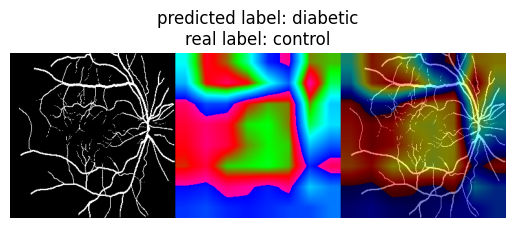

In [3]:
listpathInputImage = glob.glob('data_vessel/test/diabetic/*.tif')+glob.glob('data_vessel/test/control/*.tif')
# img_path = random.choice(listpathInputImage)
pathModel = "models/densenet_100epochs_data_vessel_randomCropRotation.pt"


h = HeatmapGenerator(pathModel, len(class_names), 256)
for img_path in listpathInputImage:
    f = h.generate(img_path, 'heatmap/vessel', 256)
f

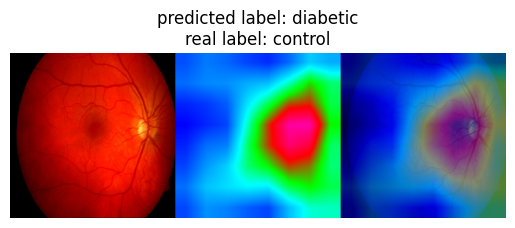

In [4]:
listpathInputImage = glob.glob('data_raw/test/diabetic/*.tif')+glob.glob('data_raw/test/control/*.tif')
# img_path = random.choice(listpathInputImage)
pathModel = "models/densenet_100epochs_data_raw_norm_randomCropRotation.pt"

h = HeatmapGenerator(pathModel, len(class_names), 256)
for img_path in listpathInputImage:
    f = h.generate(img_path, 'heatmap/raw', 256)
f

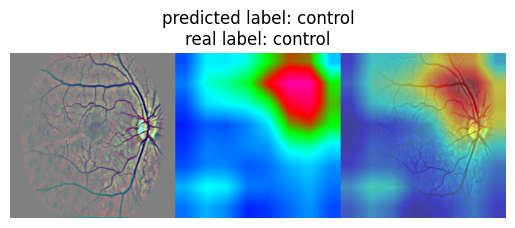

In [5]:
listpathInputImage = glob.glob('data/test/diabetic/*.png')+glob.glob('data/test/control/*.png')
img_path = random.choice(listpathInputImage)
pathModel = "models/densenet_100epochs_data_norm_randomCropRotation.pt"


h = HeatmapGenerator(pathModel, len(class_names), 256)
for img_path in listpathInputImage:
    f = h.generate(img_path, 'heatmap/prep', 256)
f